### Titanic Survival  -- Decision Tree Model

Here we will import data on Titanic passengers that either survived or died when the ship sank in 1912.  The Kaggle file train.csv will be used to develop the decision tree model and test.csv will be used to evaluate model performance. 

### Preliminaries
Load in the required library: recursive partitioning and import the training data from its origin .csv file into an R dataframe.  Inspect the contents of the data frame.

In [1]:
# Load the recursive partitioning module that will be used to generate decision tree.
library(rpart)

# Import train.csv into data frame
Titanic.train<-read.csv("Datasets/Titanic/train.csv", header=TRUE, sep=",")
#head(Titanic.train)

# Import train.csv into data frame, this is our test data for which the actual survived labels are unknown.
Titanic.test<-read.csv("Datasets/Titanic/test.csv", header=TRUE, sep=",")
#head(Titanic.test)

# .train and .test sets will be combined, temporarily, for pre-formatting to be performed on them both simultaneously
# to ensure consistency.

# Generate indices lists for each so that they can be separated afterwards.
train.set.end.index <- nrow(Titanic.train)
train.set.indices <- 1:train.set.end.index
test.set.indices <- (train.set.end.index + 1):(train.set.end.index + nrow(Titanic.test))

# Combine the data to make data cleaning easier
Survived <- Titanic.train$Survived

In [2]:
# Exclude 'Survived' column from training set and combine with test set
Titanic.combined <- rbind(Titanic.train[,!(names(Titanic.train) %in% c('Survived'))], Titanic.test)

# Report dimension of combined dataframe
dim(Titanic.combined)

# Show the top few lines of the combined dataframe
head(Titanic.combined)

[1] 1309   11

PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
1,3,"Braund, Mr. Owen Harris",male,22,1,0,A/5 21171,7.2500,,S
2,1,"Cumings, Mrs. John Bradley (Florence Briggs Thayer)",female,38,1,0,PC 17599,71.2833,C85,C
3,3,"Heikkinen, Miss. Laina",female,26,0,0,STON/O2. 3101282,7.9250,,S
4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35,1,0,113803,53.1000,C123,S
5,3,"Allen, Mr. William Henry",male,35,0,0,373450,8.0500,,S
6,3,"Moran, Mr. James",male,NA,0,0,330877,8.4583,,Q


In [3]:
# Cast Survived as factor/category levels from boolean vector
Survived <- as.factor(Survived)

# Cast Pclass as factor
Titanic.combined$Pclass <- as.factor(Titanic.combined$Pclass)

In [4]:
# Show how the training dataframe is structured
str(Titanic.combined)

'data.frame':	1309 obs. of  11 variables:
 $ PassengerId: int  1 2 3 4 5 6 7 8 9 10 ...
 $ Pclass     : Factor w/ 3 levels "1","2","3": 3 1 3 1 3 3 1 3 3 2 ...
 $ Name       : Factor w/ 1307 levels "Abbing, Mr. Anthony",..: 109 191 358 277 16 559 520 629 417 581 ...
 $ Sex        : Factor w/ 2 levels "female","male": 2 1 1 1 2 2 2 2 1 1 ...
 $ Age        : num  22 38 26 35 35 NA 54 2 27 14 ...
 $ SibSp      : int  1 1 0 1 0 0 0 3 0 1 ...
 $ Parch      : int  0 0 0 0 0 0 0 1 2 0 ...
 $ Ticket     : Factor w/ 929 levels "110152","110413",..: 524 597 670 50 473 276 86 396 345 133 ...
 $ Fare       : num  7.25 71.28 7.92 53.1 8.05 ...
 $ Cabin      : Factor w/ 187 levels "","A10","A14",..: 1 83 1 57 1 1 131 1 1 1 ...
 $ Embarked   : Factor w/ 4 levels "","C","Q","S": 4 2 4 4 4 3 4 4 4 2 ...


In [6]:
# Fill in NAs in Embarked column with Mode
x <- Titanic.combined$Embarked
y <- table(x)
mode <- names(y)[which(y==max(y))]
Titanic.combined$Embarked[Titanic.combined$Embarked == ""] <- mode
Titanic.combined$Embarked <- factor(Titanic.combined$Embarked)
levels(Titanic.combined$Embarked) <-c("Cherbourg", "Queenstown", "Southampton")

In [7]:
levels(Titanic.combined$Embarked)

[1] "Cherbourg"   "Queenstown"  "Southampton"

In [8]:
# Set any NA's in Fare column to zero.
Titanic.combined$Fare[is.na(Titanic.combined$Fare)] <- 0.0
mean(Titanic.combined$Fare)

[1] 33.27004

In [9]:
# Engineer a new feature to track which Age values are missing
Titanic.combined$AgeMissing <- as.factor(ifelse(is.na(Titanic.combined$Age), "Y", "N"))

# Insert median value for NAs in Age column
Titanic.combined$Age[is.na(Titanic.combined$Age)] <- median(Titanic.combined$Age, na.rm=TRUE)

# Change levels of Survived and Embarked factors to more meaningful values...
levels(Survived)<-c("Dead", "Survived")

# Examine the modified columns of data frame
table(Survived)
str(Survived)
str(Titanic.combined[,c('Embarked')])
str(Titanic.combined[,c('AgeMissing')])

Survived
    Dead Survived 
     549      342 

 Factor w/ 2 levels "Dead","Survived": 1 2 2 2 1 1 1 1 2 2 ...
 Factor w/ 3 levels "Cherbourg","Queenstown",..: 3 1 3 3 3 2 3 3 3 1 ...
 Factor w/ 2 levels "N","Y": 1 1 1 1 1 2 1 1 1 1 ...


In [10]:
# Count the number of family members, including spouse, parents, children each passenger reported
Titanic.combined$FamilySize <- 1 + Titanic.combined$SibSp + Titanic.combined$Parch

# Combine SibSp and Parch categories into simple yes/no for "HasFamily"
Titanic.combined$HasFamily <- as.factor(Titanic.combined$FamilySize > 1)

# Strip off room number from values in Cabin column to reduce number of levels for the category
Titanic.combined$CabinType <- as.factor(substr(as.character(Titanic.combined$Cabin),1,1))

# Make separate category to identify children
Titanic.combined$IsChild <- as.factor(Titanic.combined$Age <= 12)

# Make separate category to identify seniors
Titanic.combined$IsSenior <- as.factor(Titanic.combined$Age >= 50)

str(Titanic.combined[,c("FamilySize", "HasFamily", "CabinType", "AgeMissing", "IsChild", "IsSenior")])

'data.frame':	1309 obs. of  6 variables:
 $ FamilySize: num  2 2 1 2 1 1 1 5 3 2 ...
 $ HasFamily : Factor w/ 2 levels "FALSE","TRUE": 2 2 1 2 1 1 1 2 2 2 ...
 $ CabinType : Factor w/ 9 levels "","A","B","C",..: 1 4 1 4 1 1 6 1 1 1 ...
 $ AgeMissing: Factor w/ 2 levels "N","Y": 1 1 1 1 1 2 1 1 1 1 ...
 $ IsChild   : Factor w/ 2 levels "FALSE","TRUE": 1 1 1 1 1 1 1 2 1 1 ...
 $ IsSenior  : Factor w/ 2 levels "FALSE","TRUE": 1 1 1 1 1 1 2 1 1 1 ...


In [11]:
levels(Titanic.combined$CabinType)
sum(Titanic.combined$CabinType == "")

[1] ""  "A" "B" "C" "D" "E" "F" "G" "T"

[1] 1014

## Assess Relative "Importance" of All Features
First, all categorical features (sex, passenger class, port of embarkation) must be discretized as boolean vectors for each of their categories.  Next, use `randomForest` to calculate decrease in Accuracy and Gini similarity with inclusion/exclusion of each candidate feature.  Sort result statistics in decending order and visualize as barplot.

In [48]:
# Load the randomForest library
library(randomForest)
features <- c("Survived", "Age", "SibSp", "Parch", "Fare", "FamilySize", 
              "age_missing",
              "pclass_one", "pclass_two", "pclass_three", 
              "embarked_q", "embarked_s", "embarked_c", 
              "sex_m", "sex_f", 
              "cab_null", "cab_a", "cab_b", "cab_c", "cab_d", "cab_e", "cab_f", "cab_g", "cab_t",
              "has_fam", "is_child", "is_senior"
            )
              #"IsChild", "IsSenior", "HasFamily")

# Discretize AgeMissing feature
Titanic.combined$age_missing <- 0

# Numerically discretize (1,0) AgeMissing: "Y", "N"
Titanic.combined[Titanic.combined$AgeMissing == "Y", "age_missing"] <- 1

# Discretize Pclass feature
# initialize a column for each level
Titanic.combined$pclass_one <- 0
Titanic.combined$pclass_two <- 0
Titanic.combined$pclass_three <- 0

# Numerically discretize (1,0) Pclass: 1, 2, 3
Titanic.combined[Titanic.combined$Pclass == 1, "pclass_one"] <- 1
Titanic.combined[Titanic.combined$Pclass == 2, "pclass_two"] <- 1
Titanic.combined[Titanic.combined$Pclass == 3, "pclass_three"] <- 1

# Numerically discretize (1,0) Embarked features: "Unknown",
# "Cherbourg", "Queenstown", "Southampton"
Titanic.combined$embarked_q <- 0
Titanic.combined$embarked_s <- 0
Titanic.combined$embarked_c <- 0
Titanic.combined[Titanic.combined$Embarked == "Queenstown", "embarked_q"] <- 1
Titanic.combined[Titanic.combined$Embarked == "Southampton", "embarked_s"] <- 1
Titanic.combined[Titanic.combined$Embarked == "Cherbourg", "embarked_c"] <- 1

# Numerically discretize (1,0) Sex feature: "male", "female"
Titanic.combined$sex_m <- 0
Titanic.combined$sex_f <- 0
Titanic.combined[Titanic.combined$Sex == "male", "sex_m"] <- 1
Titanic.combined[Titanic.combined$Sex == "female", "sex_f"] <- 1

# Numerically discretize } CabinType: '' 'A' 'B' 'C' 'D' 'E' 'F' 'G' 'T' 
Titanic.combined$cab_null <- 0
Titanic.combined$cab_a <- 0
Titanic.combined$cab_b <- 0
Titanic.combined$cab_c <- 0
Titanic.combined$cab_d <- 0
Titanic.combined$cab_e <- 0
Titanic.combined$cab_f <- 0
Titanic.combined$cab_g <- 0
Titanic.combined$cab_t <- 0
Titanic.combined[Titanic.combined$CabinType == '', "cab_null"] <- 1
Titanic.combined[Titanic.combined$CabinType == 'A', "cab_a"] <- 1
Titanic.combined[Titanic.combined$CabinType == 'B', "cab_b"] <- 1
Titanic.combined[Titanic.combined$CabinType == 'C', "cab_c"] <- 1
Titanic.combined[Titanic.combined$CabinType == 'D', "cab_d"] <- 1
Titanic.combined[Titanic.combined$CabinType == 'E', "cab_e"] <- 1
Titanic.combined[Titanic.combined$CabinType == 'F', "cab_f"] <- 1
Titanic.combined[Titanic.combined$CabinType == 'G', "cab_g"] <- 1
Titanic.combined[Titanic.combined$CabinType == 'T', "cab_t"] <- 1

# Numerically discretize {0,1} HasFamily: TRUE, FALSE
Titanic.combined$has_fam <- 0
Titanic.combined[Titanic.combined$HasFamily == TRUE, "has_fam"] <- 1

# Numerically discretize {0,1} IsChild: TRUE, FALSE
Titanic.combined$is_child <- 0
Titanic.combined[Titanic.combined$IsChild == TRUE, "is_child"] <- 1

# Numerically discretize {0,1} IsSenior: TRUE, FALSE
Titanic.combined$is_senior <- 0
Titanic.combined[Titanic.combined$IsSenior == TRUE, "is_senior"] <- 1

#summary(Titanic.combined)

## Extract out titles from Names to use as another categorical predictor.

In [49]:
# Load the required library
library(stringr)
# Split name into last, title, and name
name_list <- str_split(Titanic.combined$Name, pattern="\\. |, ")
names_df <- data.frame(Reduce(rbind, name_list), stringsAsFactors=FALSE)
names(names_df) <- c("Last", "Title", "First")

Warning message in f(init, x[[i]]):
“number of columns of result is not a multiple of vector length (arg 2)”Warning message in data.row.names(row.names, rowsi, i):
“some row.names duplicated: 3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,

In [50]:
head(names_df)
head(Titanic.combined$Name)

Last,Title,First
Braund,Mr,Owen Harris
Cumings,Mrs,John Bradley (Florence Briggs Thayer)
Heikkinen,Miss,Laina
Futrelle,Mrs,Jacques Heath (Lily May Peel)
Allen,Mr,William Henry
Moran,Mr,James


[1] Braund, Mr. Owen Harris                            
[2] Cumings, Mrs. John Bradley (Florence Briggs Thayer)
[3] Heikkinen, Miss. Laina                             
[4] Futrelle, Mrs. Jacques Heath (Lily May Peel)       
[5] Allen, Mr. William Henry                           
[6] Moran, Mr. James                                   
1307 Levels: Abbing, Mr. Anthony ... Zakarian, Mr. Ortin

In [51]:
Title <- names_df$Title
Titanic.combined$Title <- data.frame(Title, stringsAsFactors=FALSE)

# Initialize numerical boolean vectors for each title in Title dataframe.
Titanic.combined$Mr <- 0
Titanic.combined$Mrs <- 0
Titanic.combined$Miss <- 0
Titanic.combined$Master <- 0
Titanic.combined$Don <- 0
Titanic.combined$Rev <- 0
Titanic.combined$Dr <- 0
Titanic.combined$Mme <- 0
Titanic.combined$Ms <- 0
Titanic.combined$Major <- 0
Titanic.combined$Lady <- 0
Titanic.combined$Sir <- 0
Titanic.combined$Mlle <- 0
Titanic.combined$Col <- 0
Titanic.combined$Capt <- 0
Titanic.combined$the_Countess <- 0
Titanic.combined$Jonkheer <- 0

# Insert occurrences of each title into corresponding boolean vectors.
Titanic.combined[Titanic.combined$Title=="Mr", "Mr"] <- 1
Titanic.combined[Titanic.combined$Title=="Mrs", "Mrs"] <- 1
Titanic.combined[Titanic.combined$Title=="Miss", "Miss"] <- 1
Titanic.combined[Titanic.combined$Title=="Master", "Master"] <- 1
Titanic.combined[Titanic.combined$Title=="Don", "Don"] <- 1
Titanic.combined[Titanic.combined$Title=="Rev", "Rev"] <- 1
Titanic.combined[Titanic.combined$Title=="Dr", "Dr"] <- 1
Titanic.combined[Titanic.combined$Title=="Mme", "Mme"] <- 1
Titanic.combined[Titanic.combined$Title=="Ms", "Ms"] <- 1
Titanic.combined[Titanic.combined$Title=="Major", "Major"] <- 1
Titanic.combined[Titanic.combined$Title=="Lady", "Lady"] <- 1
Titanic.combined[Titanic.combined$Title=="Sir", "Sir"] <- 1
Titanic.combined[Titanic.combined$Title=="Mlle", "Mlle"] <- 1
Titanic.combined[Titanic.combined$Title=="Col", "Col"] <- 1
Titanic.combined[Titanic.combined$Title=="Capt", "Capt"] <- 1
Titanic.combined[Titanic.combined$Title=="the Countess", "the_Countess"] <- 1
Titanic.combined[Titanic.combined$Title=="Jonkheer", "Jonkheer"] <- 1

features <- append(features, c("Mr", "Mrs", "Miss", "Master", "Don", "Rev", 
                   "Dr", "Mme", "Ms", "Major", "Lady", "Sir", "Mlle", 
                   "Col", "Capt", "the_Countess", "Jonkheer"))

Titanic.combined$Title <- as.factor(unlist(Titanic.combined$Title))
levels(Titanic.combined$Title)
colnames(Titanic.combined)

[1] "Capt"         "Col"          "Don"          "Dona"         "Dr"          
 [6] "Jonkheer"     "Lady"         "Major"        "Master"       "Miss"        
[11] "Mlle"         "Mme"          "Mr"           "Mrs"          "Ms"          
[16] "Rev"          "Sir"          "the Countess"

[1] "PassengerId"  "Pclass"       "Name"         "Sex"          "Age"         
 [6] "SibSp"        "Parch"        "Ticket"       "Fare"         "Cabin"       
[11] "Embarked"     "AgeMissing"   "FamilySize"   "HasFamily"    "CabinType"   
[16] "IsChild"      "IsSenior"     "age_missing"  "pclass_one"   "pclass_two"  
[21] "pclass_three" "embarked_q"   "embarked_s"   "embarked_c"   "sex_m"       
[26] "sex_f"        "cab_null"     "cab_a"        "cab_b"        "cab_c"       
[31] "cab_d"        "cab_e"        "cab_f"        "cab_g"        "cab_t"       
[36] "has_fam"      "is_child"     "is_senior"    "Title"        "Mr"          
[41] "Mrs"          "Miss"         "Master"       "Don"          "Rev"         
[46] "Dr"           "Mme"          "Ms"           "Major"        "Lady"        
[51] "Sir"          "Mlle"         "Col"          "Capt"         "the_Countess"
[56] "Jonkheer"     "Cluster"

## Use k-means to cluster passengers by similarity of their features

Here we will normalize each of the feature vectors, after they have been enumerated (if necessary) so that they may be grouped by similarity via the k-means clustering algorithm.  A new feature vector that categorizes each record by its cluster assignment will then be added to the `Titanic.combined` data.frame for potential use in models that follow.

In [52]:
features

[1] "Survived"     "Age"          "SibSp"        "Parch"        "Fare"        
 [6] "FamilySize"   "age_missing"  "pclass_one"   "pclass_two"   "pclass_three"
[11] "embarked_q"   "embarked_s"   "embarked_c"   "sex_m"        "sex_f"       
[16] "cab_null"     "cab_a"        "cab_b"        "cab_c"        "cab_d"       
[21] "cab_e"        "cab_f"        "cab_g"        "cab_t"        "has_fam"     
[26] "is_child"     "is_senior"    "Mr"           "Mrs"          "Miss"        
[31] "Master"       "Don"          "Rev"          "Dr"           "Mme"         
[36] "Ms"           "Major"        "Lady"         "Sir"          "Mlle"        
[41] "Col"          "Capt"         "the_Countess" "Jonkheer"

In [29]:
# Load the required library
# NOTE: Please ignore the warning message.
library(caret)
clustering.features <- c("Pclass", "Sex", "Age", "SibSp", "Parch", 
              "Fare", "Embarked", "FamilySize", "AgeMissing",
              "HasFamily", "IsChild", "IsSenior")
dummy.vars <- dummyVars(~ ., Titanic.combined[, clustering.features])
titanic.dummy <- predict(dummy.vars, Titanic.combined[, features])
head(titanic.dummy)

,Pclass.1,Pclass.2,Pclass.3,Sex.female,Sex.male,Age,SibSp,Parch,Fare,Embarked.Cherbourg,⋯,Embarked.Southampton,FamilySize,AgeMissing.N,AgeMissing.Y,HasFamily.FALSE,HasFamily.TRUE,IsChild.FALSE,IsChild.TRUE,IsSenior.FALSE,IsSenior.TRUE
1,0,0,1,0,1,22,1,0,7.2500,0,⋯,1,2,1,0,0,1,1,0,1,0
2,1,0,0,1,0,38,1,0,71.2833,1,⋯,0,2,1,0,0,1,1,0,1,0
3,0,0,1,1,0,26,0,0,7.9250,0,⋯,1,1,1,0,1,0,1,0,1,0
4,1,0,0,1,0,35,1,0,53.1000,0,⋯,1,2,1,0,0,1,1,0,1,0
5,0,0,1,0,1,35,0,0,8.0500,0,⋯,1,1,1,0,1,0,1,0,1,0
6,0,0,1,0,1,28,0,0,8.4583,0,⋯,0,1,0,1,1,0,1,0,1,0


In [30]:
# Each of the features have values that span different numerical ranges.  Here we will center 
# and scale (normalize) each of the features for k-means.
#titanic.dummy <- scale(titanic.dummy)
titanic.dummy <- scale(titanic.dummy)
head(titanic.dummy)

,Pclass.1,Pclass.2,Pclass.3,Sex.female,Sex.male,Age,SibSp,Parch,Fare,Embarked.Cherbourg,⋯,Embarked.Southampton,FamilySize,AgeMissing.N,AgeMissing.Y,HasFamily.FALSE,HasFamily.TRUE,IsChild.FALSE,IsChild.TRUE,IsSenior.FALSE,IsSenior.TRUE
1,-0.5721328,-0.5178859,0.9195737,-0.7432129,0.7432129,-0.5814061,0.4811039,-0.4448295,-0.5028313,-0.5095751,⋯,0.6547607,0.07332427,0.5012404,-0.5012404,-1.2332863,1.2332863,0.2780416,-0.2780416,0.3027755,-0.3027755
2,1.7465107,-0.5178859,-1.0866296,1.3444816,-1.3444816,0.6584003,0.4811039,-0.4448295,0.7345974,1.9609203,⋯,-1.5261088,0.07332427,0.5012404,-0.5012404,-1.2332863,1.2332863,0.2780416,-0.2780416,0.3027755,-0.3027755
3,-0.5721328,-0.5178859,0.9195737,1.3444816,-1.3444816,-0.2714545,-0.4789037,-0.4448295,-0.4897871,-0.5095751,⋯,0.6547607,-0.55813274,0.5012404,-0.5012404,0.8102223,-0.8102223,0.2780416,-0.2780416,0.3027755,-0.3027755
4,1.7465107,-0.5178859,-1.0866296,1.3444816,-1.3444816,0.4259366,0.4811039,-0.4448295,0.3832093,-0.5095751,⋯,0.6547607,0.07332427,0.5012404,-0.5012404,-1.2332863,1.2332863,0.2780416,-0.2780416,0.3027755,-0.3027755
5,-0.5721328,-0.5178859,0.9195737,-0.7432129,0.7432129,0.4259366,-0.4789037,-0.4448295,-0.4873715,-0.5095751,⋯,0.6547607,-0.55813274,0.5012404,-0.5012404,0.8102223,-0.8102223,0.2780416,-0.2780416,0.3027755,-0.3027755
6,-0.5721328,-0.5178859,0.9195737,-0.7432129,0.7432129,-0.1164787,-0.4789037,-0.4448295,-0.4794812,-0.5095751,⋯,-1.5261088,-0.55813274,-1.9935265,1.9935265,0.8102223,-0.8102223,0.2780416,-0.2780416,0.3027755,-0.3027755


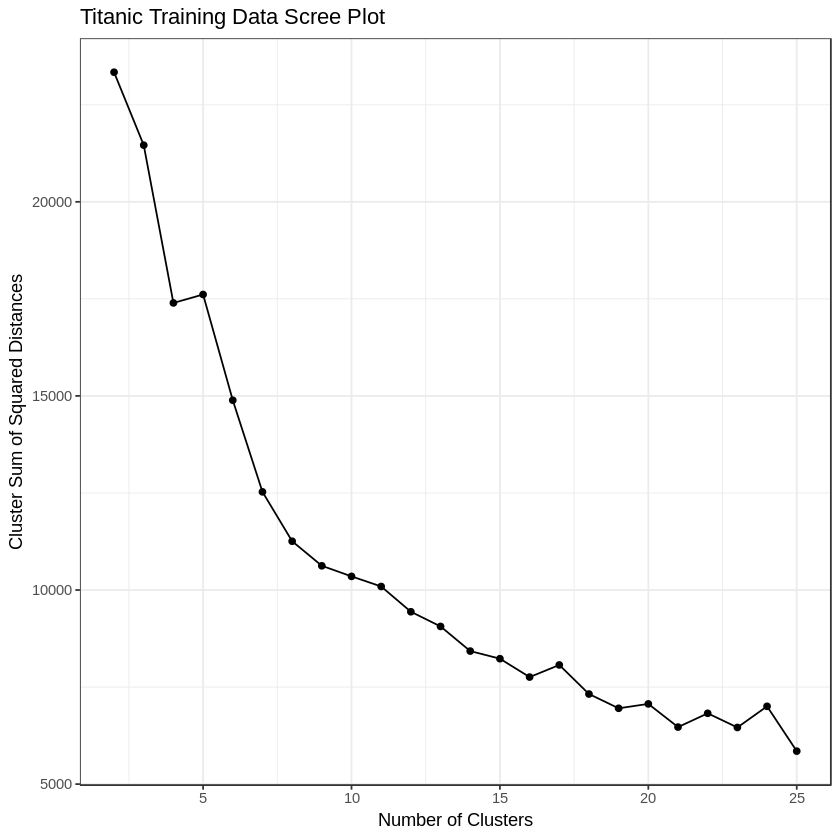

In [43]:
# Vary number k of clusters to use from 2 to 15, and repeat k-means clustering for each
# value of k.  Store total sum-of-squared distances across k clusters on each iteration.  Use
# Examine resultant vector for kink (elbow) in progressive decline in error.
max.k <- 25
clusters.sum.squares <- rep(0.0, max.k - 1)
cluster.params <- 2:max.k

for (i in cluster.params) {
    # Cluster data using k-means with the current value of i.
    kmeans.temp <- kmeans(titanic.dummy, centers = i)
    
    # Get the total sum of squared distances for all points
    # in the cluster and store it for plotting later.
    clusters.sum.squares[i - 1] <- sum(kmeans.temp$withinss)
}

# build the scree plot
# Load the required library
library(ggplot2)
# Plot our scree plot using the mighty ggplot2.
ggplot(NULL, aes(x=cluster.params, y=clusters.sum.squares)) +
  theme_bw() +
  geom_point() +
  geom_line() +
  labs(x="Number of Clusters",
       y="Cluster Sum of Squared Distances",
       title="Titanic Training Data Scree Plot")

In [44]:
# Cluster the data using the k value determined by the location of elbow in plot above.
# Add cluster assignments to the combined (train + test) data.frame.
num.clusters <- 8
titanic.kmeans <- kmeans(titanic.dummy, centers = num.clusters)
Titanic.combined$Cluster <- as.factor(titanic.kmeans$cluster)

In [45]:
# Now separate the .train and .test sets
Titanic.train <- Titanic.combined[train.set.indices,]
Titanic.test <- Titanic.combined[test.set.indices,]

# Insert Survived factor back into the .train dataset
Titanic.train$Survived <- Survived
head(Titanic.train, addrownums = TRUE)
head(Titanic.test)
#row.names(Titanic.train)

PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,⋯,Major,Lady,Sir,Mlle,Col,Capt,the_Countess,Jonkheer,Cluster,Survived
1,3,"Braund, Mr. Owen Harris",male,22,1,0,A/5 21171,7.2500,,⋯,0,0,0,0,0,0,0,0,1,Dead
2,1,"Cumings, Mrs. John Bradley (Florence Briggs Thayer)",female,38,1,0,PC 17599,71.2833,C85,⋯,0,0,0,0,0,0,0,0,3,Survived
3,3,"Heikkinen, Miss. Laina",female,26,0,0,STON/O2. 3101282,7.9250,,⋯,0,0,0,0,0,0,0,0,1,Survived
4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35,1,0,113803,53.1000,C123,⋯,0,0,0,0,0,0,0,0,3,Survived
5,3,"Allen, Mr. William Henry",male,35,0,0,373450,8.0500,,⋯,0,0,0,0,0,0,0,0,1,Dead
6,3,"Moran, Mr. James",male,28,0,0,330877,8.4583,,⋯,0,0,0,0,0,0,0,0,8,Dead


,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,⋯,Ms,Major,Lady,Sir,Mlle,Col,Capt,the_Countess,Jonkheer,Cluster
892,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,,⋯,0,0,0,0,0,0,0,0,0,8
893,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,,⋯,0,0,0,0,0,0,0,0,0,1
894,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,,⋯,0,0,0,0,0,0,0,0,0,5
895,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,,⋯,0,0,0,0,0,0,0,0,0,1
896,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,,⋯,0,0,0,0,0,0,0,0,0,1
897,897,3,"Svensson, Mr. Johan Cervin",male,14.0,0,0,7538,9.2250,,⋯,0,0,0,0,0,0,0,0,0,1


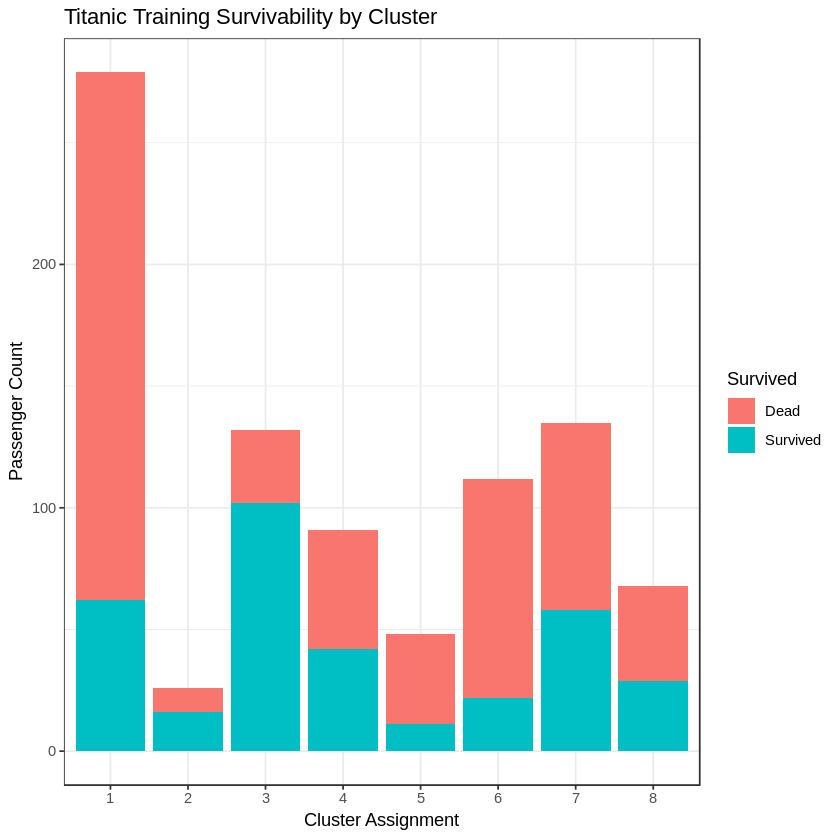

In [46]:
# Visualize survivability by cluster assignment.
ggplot(Titanic.train, aes(x=Cluster, fill=Survived)) +
  theme_bw() +
  geom_bar() +
  labs(x="Cluster Assignment",
       y="Passenger Count",
       title="Titanic Training Survivability by Cluster")

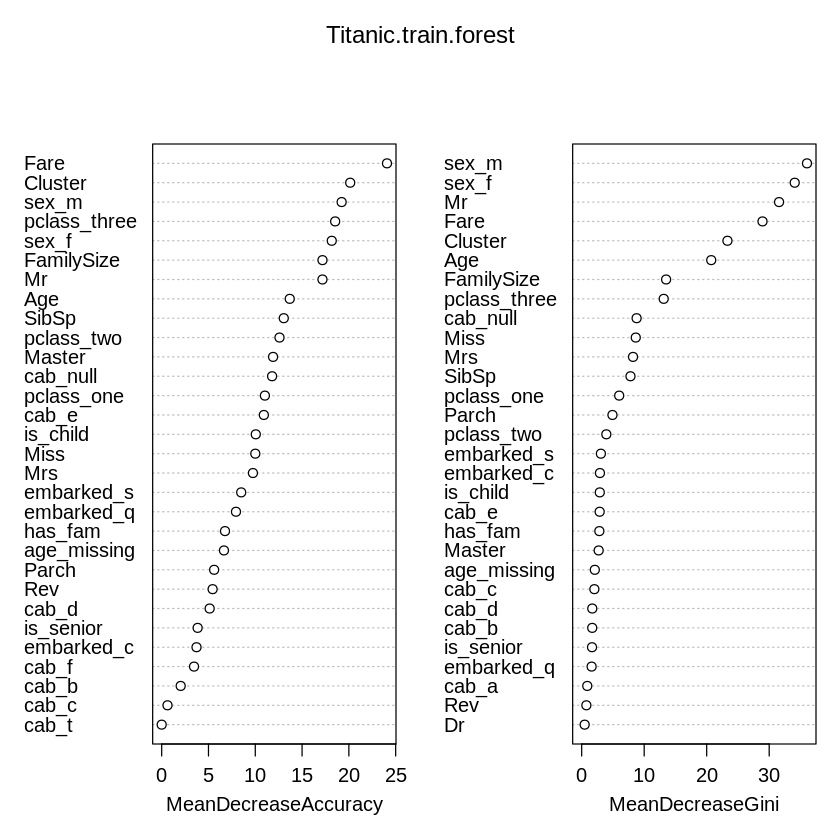

In [54]:
features <- append(features, "Cluster")
Titanic.train.forest <- randomForest(Survived ~ ., data = Titanic.train[, features], importance=TRUE)
varImpPlot(Titanic.train.forest)

In [75]:
ranking.features <- c("Pclass", "Sex", "Age", "SibSp", "Parch", 
                        "Fare", "Embarked", "FamilySize", "AgeMissing",
                        "HasFamily", "IsChild", "IsSenior", "CabinType",
                        "Cluster", "Title")
dummy.vars <- dummyVars(~ ., Titanic.train[, ranking.features])
Titanic.train.dummy <- predict(dummy.vars, Titanic.train[, ranking.features])
colnames(Titanic.train.dummy)[colnames(Titanic.train.dummy) == "Title.the Countess"] <- "Title.the_Countess"
#Titanic.train.dummy[,"Title.the_Countess"]

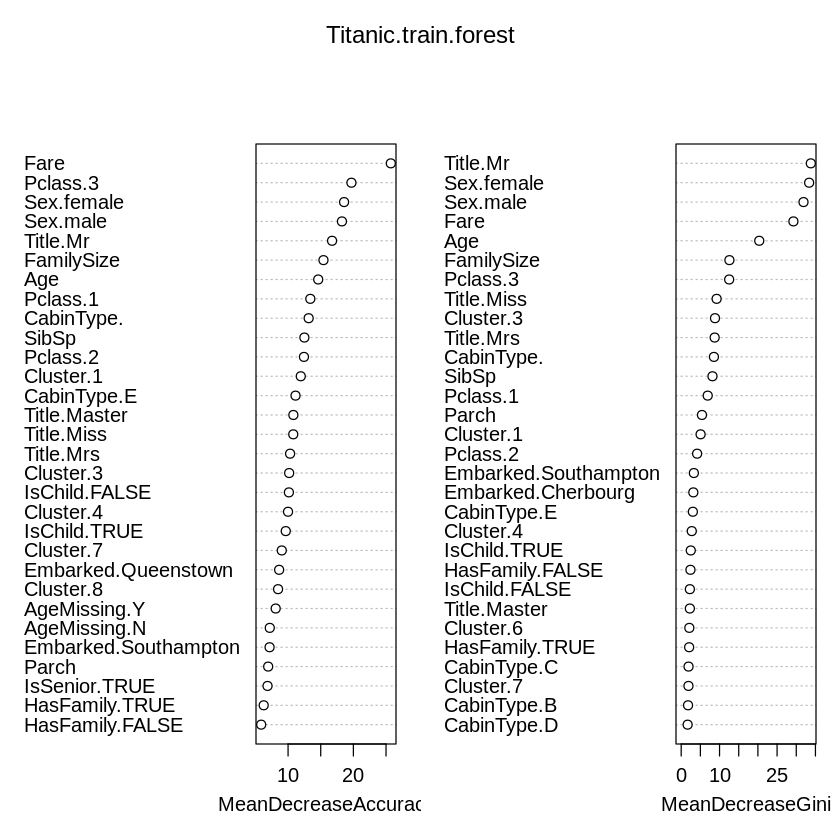

In [76]:
Titanic.train.forest <- randomForest(Survived ~ ., data = Titanic.train.dummy, importance=TRUE)
varImpPlot(Titanic.train.forest)

In [77]:
# Examine summary statistics of the training data.
class(Titanic.train)
summary(Survived)

[1] "data.frame"

Dead Survived 
     549      342

### Build a Single Decision Tree Model
Begin by randomly sampling training and testing subsets from this total training dataset.  We will use this to appraise the accuracy of the approach prior to incorporating the entire set of training data to build the decision tree.

In [79]:
subtrain.index <- sample(1:nrow(Titanic.train), 0.7*nrow(Titanic.train), replace = FALSE)
Titanic.subtrain <- Titanic.train[subtrain.index, ]
Titanic.subtest <- Titanic.train[-subtrain.index, ]
str(Titanic.subtrain)
str(Titanic.subtest)

'data.frame':	623 obs. of  58 variables:
 $ PassengerId : int  289 256 756 457 613 844 454 752 438 646 ...
 $ Pclass      : Factor w/ 3 levels "1","2","3": 2 3 2 1 3 3 1 3 2 1 ...
 $ Name        : Factor w/ 1307 levels "Abbing, Mr. Anthony",..: 383 824 326 542 573 475 295 554 693 337 ...
 $ Sex         : Factor w/ 2 levels "female","male": 2 1 2 2 1 2 2 2 1 2 ...
 $ Age         : num  42 29 0.67 65 28 34.5 49 6 24 48 ...
 $ SibSp       : int  0 0 1 0 1 0 1 0 2 1 ...
 $ Parch       : int  0 2 1 0 0 0 0 1 3 0 ...
 $ Ticket      : Factor w/ 929 levels "110152","110413",..: 135 186 167 74 445 206 85 487 238 588 ...
 $ Fare        : num  13 15.2 14.5 26.6 15.5 ...
 $ Cabin       : Factor w/ 187 levels "","A10","A14",..: 1 1 1 128 1 1 88 120 1 103 ...
 $ Embarked    : Factor w/ 3 levels "Cherbourg","Queenstown",..: 3 1 3 3 2 1 1 3 3 1 ...
 $ AgeMissing  : Factor w/ 2 levels "N","Y": 1 1 1 1 2 1 1 1 1 1 ...
 $ FamilySize  : num  1 3 3 1 2 1 2 2 6 2 ...
 $ HasFamily   : Factor w/ 2 levels "FAL

In [80]:
# Compute decision tree
model_spec <- c('Survived', 'Sex', 'Pclass', 'Age', 'Fare', 'Embarked', 
                'FamilySize', 'Cluster')

train_control <- rpart.control()
parms_control <- list(split="gini")

titanic.tree <- rpart(Survived ~ ., 
                        data = Titanic.subtrain[model_spec], 
                        method="class", parms=parms_control,
                        control = train_control, model=TRUE)

In [81]:
as.formula(titanic.tree)

Survived ~ Sex + Pclass + Age + Fare + Embarked + FamilySize + 
    Cluster
attr(,"variables")
list(Survived, Sex, Pclass, Age, Fare, Embarked, FamilySize, 
    Cluster)
attr(,"factors")
           Sex Pclass Age Fare Embarked FamilySize Cluster
Survived     0      0   0    0        0          0       0
Sex          1      0   0    0        0          0       0
Pclass       0      1   0    0        0          0       0
Age          0      0   1    0        0          0       0
Fare         0      0   0    1        0          0       0
Embarked     0      0   0    0        1          0       0
FamilySize   0      0   0    0        0          1       0
Cluster      0      0   0    0        0          0       1
attr(,"term.labels")
[1] "Sex"        "Pclass"     "Age"        "Fare"       "Embarked"  
[6] "FamilySize" "Cluster"   
attr(,"order")
[1] 1 1 1 1 1 1 1
attr(,"intercept")
[1] 1
attr(,"response")
[1] 1
attr(,"predvars")
list(Survived, Sex, Pclass, Age, Fare, Embarked, FamilySize, 


In [82]:
titanic.tree
as.formula(titanic.tree)

n= 623 

node), split, n, loss, yval, (yprob)
      * denotes terminal node

 1) root 623 241 Dead (0.6131621 0.3868379)  
   2) Sex=male 398  73 Dead (0.8165829 0.1834171)  
     4) Cluster=1,5,6,7,8 329  41 Dead (0.8753799 0.1246201) *
     5) Cluster=2,3,4 69  32 Dead (0.5362319 0.4637681)  
      10) FamilySize>=5 15   0 Dead (1.0000000 0.0000000) *
      11) FamilySize< 5 54  22 Survived (0.4074074 0.5925926)  
        22) Age>=10 39  17 Dead (0.5641026 0.4358974) *
        23) Age< 10 15   0 Survived (0.0000000 1.0000000) *
   3) Sex=female 225  57 Survived (0.2533333 0.7466667)  
     6) Pclass=3 100  49 Dead (0.5100000 0.4900000)  
      12) Fare>=23.7 15   2 Dead (0.8666667 0.1333333) *
      13) Fare< 23.7 85  38 Survived (0.4470588 0.5529412)  
        26) Cluster=1,6 48  21 Dead (0.5625000 0.4375000)  
          52) Fare>=7.7 39  13 Dead (0.6666667 0.3333333) *
          53) Fare< 7.7 9   1 Survived (0.1111111 0.8888889) *
        27) Cluster=3,4,5,8 37  11 Survived (0.2972

Survived ~ Sex + Pclass + Age + Fare + Embarked + FamilySize + 
    Cluster
attr(,"variables")
list(Survived, Sex, Pclass, Age, Fare, Embarked, FamilySize, 
    Cluster)
attr(,"factors")
           Sex Pclass Age Fare Embarked FamilySize Cluster
Survived     0      0   0    0        0          0       0
Sex          1      0   0    0        0          0       0
Pclass       0      1   0    0        0          0       0
Age          0      0   1    0        0          0       0
Fare         0      0   0    1        0          0       0
Embarked     0      0   0    0        1          0       0
FamilySize   0      0   0    0        0          1       0
Cluster      0      0   0    0        0          0       1
attr(,"term.labels")
[1] "Sex"        "Pclass"     "Age"        "Fare"       "Embarked"  
[6] "FamilySize" "Cluster"   
attr(,"order")
[1] 1 1 1 1 1 1 1
attr(,"intercept")
[1] 1
attr(,"response")
[1] 1
attr(,"predvars")
list(Survived, Sex, Pclass, Age, Fare, Embarked, FamilySize, 


ERROR: Error in rpartco(x): no information available on parameters from previous call to plot()


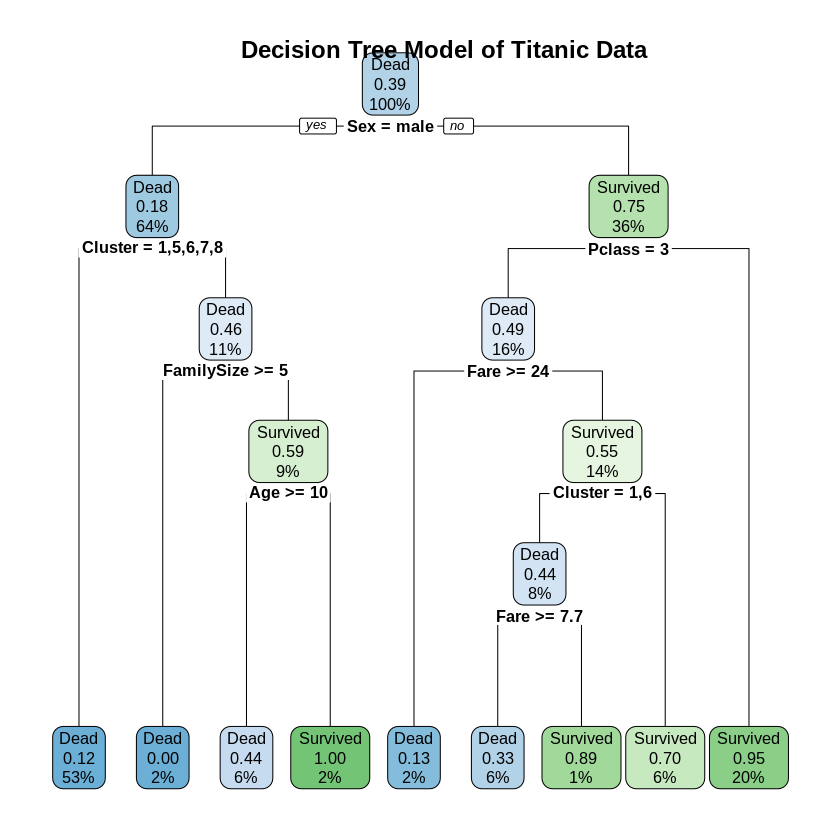

In [83]:
# Visualize the model
# Plot the tree structure
library(rpart.plot)
rpart.plot(titanic.tree)
title(main = "Decision Tree Model of Titanic Data")
text(titanic.tree, use.n = TRUE)

In [84]:
# Predict survival of passengers in the the Titanic.subtest dataset using the decision model
Titanic.subtest.predictions <- predict(titanic.tree, Titanic.subtest, type="class")
head(Titanic.subtest.predictions)

2        3        8       10       12       14 
Survived     Dead     Dead Survived Survived     Dead 
Levels: Dead Survived

In [85]:
# Predicted values can also be probabilities,instead of class labels
Titanic.subtest.predictions.prob <- predict(titanic.tree, Titanic.subtest, type = "prob")
head(Titanic.subtest.predictions.prob)

,Dead,Survived
2,0.0480000,0.9520000
3,0.6666667,0.3333333
8,1.0000000,0.0000000
10,0.0480000,0.9520000
12,0.0480000,0.9520000
14,1.0000000,0.0000000


In [86]:
# Comparison table of actual values and predicted values
Titanic.comparison <- Titanic.subtest
Titanic.comparison$Predictions <- Titanic.subtest.predictions
head(Titanic.comparison[ , c("Survived", "Predictions")])

,Survived,Predictions
2,Survived,Survived
3,Survived,Dead
8,Dead,Dead
10,Survived,Survived
12,Survived,Survived
14,Dead,Dead


In [87]:
# View misclassified rows
disagreement.index <- Titanic.comparison$Survived != Titanic.comparison$Predictions 
head(Titanic.comparison[disagreement.index, ])
sum(disagreement.index)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,⋯,Lady,Sir,Mlle,Col,Capt,the_Countess,Jonkheer,Cluster,Survived,Predictions
3,3,3,"Heikkinen, Miss. Laina",female,26,0,0,STON/O2. 3101282,7.9250,,⋯,0,0,0,0,0,0,0,1,Survived,Dead
22,22,2,"Beesley, Mr. Lawrence",male,34,0,0,248698,13.0000,D56,⋯,0,0,0,0,0,0,0,7,Survived,Dead
24,24,1,"Sloper, Mr. William Thompson",male,28,0,0,113788,35.5000,A6,⋯,0,0,0,0,0,0,0,1,Survived,Dead
37,37,3,"Mamee, Mr. Hanna",male,28,0,0,2677,7.2292,,⋯,0,0,0,0,0,0,0,6,Survived,Dead
82,82,3,"Sheerlinck, Mr. Jan Baptist",male,29,0,0,345779,9.5000,,⋯,0,0,0,0,0,0,0,1,Survived,Dead
110,110,3,"Moran, Miss. Bertha",female,28,1,0,371110,24.1500,,⋯,0,0,0,0,0,0,0,8,Survived,Dead


[1] 51

In [88]:
# Build the confusion matrix
titanic.dt.confusion <- table(Titanic.comparison$Predictions, Titanic.subtest[,"Survived"])
print(titanic.dt.confusion)

          
           Dead Survived
  Dead      159       43
  Survived    8       58


In [89]:
# Accuracy
titanic.dt.accuracy <- sum(diag(titanic.dt.confusion)) / sum(titanic.dt.confusion)
cat("Accuracy: ", titanic.dt.accuracy)
# Precision
titanic.dt.precision <- titanic.dt.confusion[2,2] / sum(titanic.dt.confusion[2,])
cat("\nPrecision: ", titanic.dt.precision)
# Recall
titanic.dt.recall <- titanic.dt.confusion[2,2] / sum(titanic.dt.confusion[,2])
cat("\nRecall: ", titanic.dt.recall)
# F1 score
titanic.dt.F1 <- 2 * titanic.dt.precision * titanic.dt.recall / (titanic.dt.precision + titanic.dt.recall)
cat("\nF1-score: ", titanic.dt.F1)

Accuracy:  0.8097015
Precision:  0.8787879
Recall:  0.5742574
F1-score:  0.6946108

### Perform Grid Search to Determine Optimal Hyperparameters

Generate the grid of all possible hyperparameter combinations on which to perform search.

In [90]:
# Grid search across all possible hyperparameters
tune.grid <- expand.grid(maxdepth=2:6, minsplit=2:6, minbucket=2:10, accuracy=0.00)
#tune.grid

Iterate over all rows of the grid table generated above, calculating model accuracy for each iteration.

In [91]:
for(i in 1:nrow(tune.grid)){
  titanic.tree.3 <- rpart(as.formula(titanic.tree), data=Titanic.train, 
                         control=rpart.control(maxdepth=tune.grid[i,1], 
                                               minsplit=tune.grid[i,2], 
                                               minbucket=tune.grid[i,3]))
  titanic.predictions <- predict(titanic.tree.3, Titanic.subtest, type="class")
  titanic.confusion <- table(titanic.predictions, Titanic.subtest$Survived)
  titanic.accuracy <- sum(diag(titanic.confusion)) / sum(titanic.confusion)
  tune.grid[i,4] <- titanic.accuracy
    }

#tune.grid
# Select the tuned model with highest accuracy
best.tuned.params <- tune.grid[which.max(tune.grid$accuracy),]
best.tuned.params

# Insert optimized hyperparameters into rpart.control function definition
train_control.best <- rpart.control(maxdepth=best.tuned.params[1], 
                                    minsplit=best.tuned.params[2], 
                                    minbucket=best.tuned.params[3])

,maxdepth,minsplit,minbucket,accuracy
130,6,2,7,0.8432836


## Perform k-fold Cross-Validation on Single Decision Tree

In [92]:
# Load the required package
library(caret)
# Set up caret to perform 10-fold cross validation repeated 3 times
caret.control <- trainControl(method = "repeatedcv",
                              number = 10,
                              repeats = 3)

In [93]:
library(e1071)
# Use caret to train the rpart decision tree using 10-fold cross 
# validation repeated 3 times and use 15 values for tuning the
# cp parameter for rpart. This code returns the best model trained
# on all the data! Mighty!

model_to_eval <- titanic.tree
#model_to_eval <- Titanic.rf.model
rpart.cv <- train(as.formula(model_to_eval), data=Titanic.train, 
                  method = "rpart",
                  control = train_control.best,
                  trControl = caret.control,
                  tuneLength = 15)

In [94]:
# Display the results of the cross validation run
rpart.cv

CART 

891 samples
  7 predictor
  2 classes: 'Dead', 'Survived' 

No pre-processing
Resampling: Cross-Validated (10 fold, repeated 3 times) 
Summary of sample sizes: 803, 802, 802, 802, 802, 802, ... 
Resampling results across tuning parameters:

  cp          Accuracy   Kappa    
  0.00000000  0.8073118  0.5823267
  0.03174603  0.7882605  0.5426738
  0.06349206  0.7867582  0.5421603
  0.09523810  0.7867582  0.5421603
  0.12698413  0.7867582  0.5421603
  0.15873016  0.7867582  0.5421603
  0.19047619  0.7867582  0.5421603
  0.22222222  0.7867582  0.5421603
  0.25396825  0.7867582  0.5421603
  0.28571429  0.7867582  0.5421603
  0.31746032  0.7867582  0.5421603
  0.34920635  0.7867582  0.5421603
  0.38095238  0.7867582  0.5421603
  0.41269841  0.7867582  0.5421603
  0.44444444  0.7029380  0.2929802

Accuracy was used to select the optimal model using the largest value.
The final value used for the model was cp = 0.

In [95]:
# What is the standard deviation?
cat(paste("\nCross validation standard deviation:",  
          sd(rpart.cv$resample$Accuracy), "\n", sep = " "))


Cross validation standard deviation: 0.0440658555393099 


In [96]:
# Pull out the the trained model using the best parameters on
# all the data! Mighty!
rpart.best <- rpart.cv$finalModel

In [97]:
# Look at the model - this model is trained on 100% of the data!
rpart.best

n= 891 

node), split, n, loss, yval, (yprob)
      * denotes terminal node

  1) root 891 342 Dead (0.61616162 0.38383838)  
    2) Sexmale>=0.5 577 109 Dead (0.81109185 0.18890815)  
      4) Age>=6.5 553  93 Dead (0.83182640 0.16817360) *
      5) Age< 6.5 24   8 Survived (0.33333333 0.66666667)  
       10) FamilySize>=4.5 9   1 Dead (0.88888889 0.11111111) *
       11) FamilySize< 4.5 15   0 Survived (0.00000000 1.00000000) *
    3) Sexmale< 0.5 314  81 Survived (0.25796178 0.74203822)  
      6) Pclass3>=0.5 144  72 Dead (0.50000000 0.50000000)  
       12) Fare>=23.35 27   3 Dead (0.88888889 0.11111111) *
       13) Fare< 23.35 117  48 Survived (0.41025641 0.58974359)  
         26) Age>=36.5 7   1 Dead (0.85714286 0.14285714) *
         27) Age< 36.5 110  42 Survived (0.38181818 0.61818182)  
           54) EmbarkedSouthampton>=0.5 57  27 Survived (0.47368421 0.52631579)  
            108) Fare< 10.825 33  14 Dead (0.57575758 0.42424242) *
            109) Fare>=10.825 24   8 S

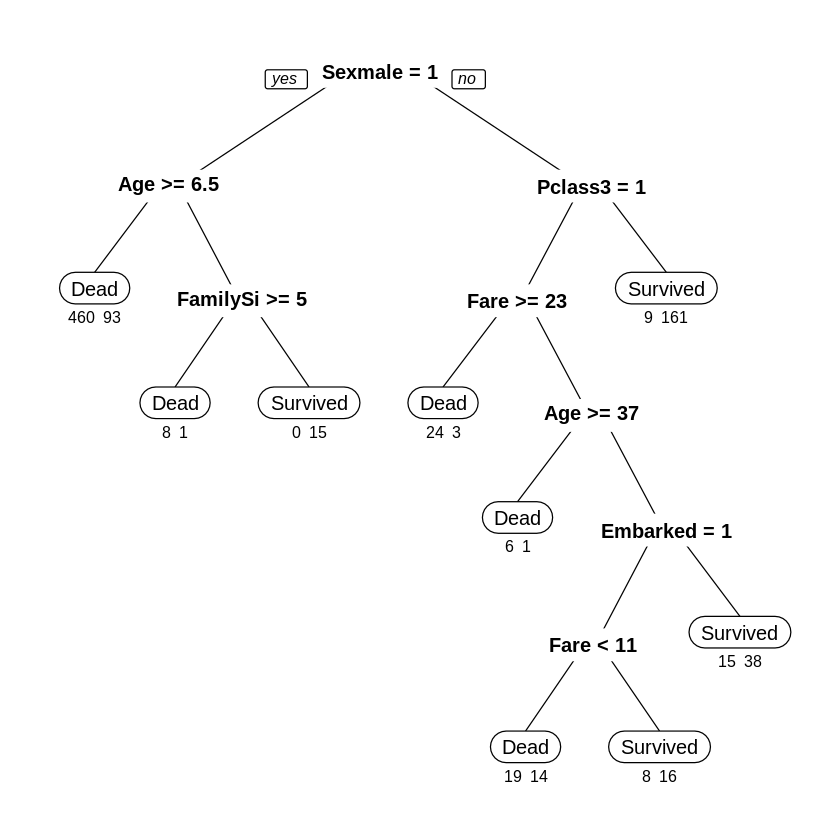

In [98]:
# Load the required package
library(rpart.plot)
# Make the model look pretty
prp(rpart.best, type = 0, extra = 1, under = TRUE)

### Generate Complete Model and Make Predictions on Test Set

In [ ]:
# Produce predictions using complete decision tree
Titanic.test.predictions <- predict(rpart.cv, Titanic.test, type = "raw")
head(Titanic.test.predictions)

# Predicted values can also be probabilities,instead of class labels
Titanic.test.predictions.prob <- predict(rpart.cv, Titanic.test, type = "prob")
head(Titanic.test.predictions.prob)

In [ ]:
str(Titanic.test)

In [ ]:
Survived<-as.numeric(Titanic.test.predictions == "Survived")
PassengerId<-Titanic.test$PassengerId
out.df<-data.frame(PassengerId, Survived)

In [ ]:
head(out.df)

In [ ]:
write.csv(out.df, "Datasets/Titanic/survival_predictions_dt8.csv", row.names=FALSE)

In [ ]:
names(table(Titanic.subtest$Survived))[max.col(table(Titanic.subtest$Survived))]

In [ ]:
names(table(Titanic.subtest$Survived))[which.max(as.vector(table(Titanic.subtest$Survived)))]

In [ ]:
testing.set[1,]

In [ ]:
testing.set <- Titanic.subtest
TreeArray <- vector("list", length = nTrees)
TreePredictions <- vector("list", length = nTrees)
TreeArray[[1]] <- titanic.tree
TreeArray[[1]]
TreeArray[[2]]
TreePredictions[[1]]
TreePredictions[[1]] <- predict(TreeArray[[1]], testing.set[89,], type="class")
TreePredictions[[1]]

In [ ]:
# Dataset to train on
training.set <- Titanic.subtrain
nTrainingSamples <- nrow(training.set)
train.indices = 1:nTrainingSamples

training.sample.indices <- sample(train.indices, nTrainingSamples, replace = TRUE)
training.sample.set <- training.set[training.sample.indices,]

    TreeArray[[2]] <- rpart(as.formula(titanic.tree), data = training.sample.set,
                            method = "class", parms = parms_control,

                            control = train_control.best)
TreeArray[[1]]
TreeArray[[2]]
TreeArray[[3]]

## Ensemble of Bagged Decision Trees Approach

In [111]:
# Specifies number of trees to fit that will comprise forest
nTrees <- 51

# Dataset to train on
training.set <- Titanic.subtrain
nTrainingSamples <- nrow(training.set)
train.indices <- 1:nTrainingSamples

levels_list <- levels(training.set$Survived)

# Dataset to test on
testing.set <- Titanic.subtest
nTestingSamples <- nrow(testing.set)
#testing.set$Survived <- factor(sample(levels_list, nTestingSamples, replace = TRUE))

# Initialize loop arrays
TreeArray <- vector("list", length = nTrees)
TreePredictions <- vector("character", length = nTrees)

ForestPredictions <- vector("character", length = nTestingSamples)

# Fit trees to randomly-sampled (with replacement) subsets of training data
for (i in 1:nTrees){
    
    training.sample.indices <- sample(train.indices, nTrainingSamples, replace = TRUE)
    training.sample.set <- training.set[training.sample.indices,]
    
    TreeArray[[i]] <- rpart(as.formula(titanic.tree), data = training.sample.set,
                            method = "class", parms = parms_control,
                            control = train_control.best, model = TRUE)
}

In [108]:
levels_list[which.max(table(predict(TreeArray[[11]], testing.set[2,], type="class")))]

[1] "Dead"

In [112]:
# For each element (row) of the test set dataframe, have all trees generate predictions for that
# instance and use the majority as the forest decision
for (j in 1:nTestingSamples){
    
    for (i in 1:nTrees){
        
        TreePredictions[i] <- levels_list[which.max(table(predict(TreeArray[[i]], testing.set[j,], type="class")))]
    }
    
    TreePredictions <- as.factor(TreePredictions)
    levels(TreePredictions) <- levels_list
    ForestPredictions[j] <- levels_list[which.max(table(TreePredictions))]
}

In [113]:
# Comparison table of actual values and predicted values
Titanic.comparison <- testing.set
Titanic.comparison$Predictions <- as.factor(unlist(ForestPredictions))
titanic.dt.confusion <- table(Titanic.comparison[,c("Predictions","Survived")])

# Accuracy
titanic.dt.accuracy <- sum(diag(titanic.dt.confusion)) / sum(titanic.dt.confusion)
cat("Accuracy: ", titanic.dt.accuracy)
# Precision
titanic.dt.precision <- titanic.dt.confusion[2,2] / sum(titanic.dt.confusion[2,])
cat("\nPrecision: ", titanic.dt.precision)
# Recall
titanic.dt.recall <- titanic.dt.confusion[2,2] / sum(titanic.dt.confusion[,2])
cat("\nRecall: ", titanic.dt.recall)
# F1 score
titanic.dt.F1 <- 2 * titanic.dt.precision * titanic.dt.recall / (titanic.dt.precision + titanic.dt.recall)
cat("\nF1-score: ", titanic.dt.F1)

Accuracy:  0.8097015
Precision:  0.8676471
Recall:  0.5841584
F1-score:  0.6982249

In [114]:
table(as.factor(ForestPredictions))


    Dead Survived 
     200       68 

In [ ]:
Survived<-as.numeric(ForestPredictions == "Survived")
PassengerId<-testing.set$PassengerId
out.df<-data.frame(PassengerId, Survived)
write.csv(out.df, "Datasets/Titanic/survival_predictions_dt15.csv", row.names=FALSE)

In [ ]:
# Comparison table of actual values and predicted values
Titanic.comparison <- testing.set
Titanic.comparison$Predictions <- as.factor(ForestPredictions)

# Build the confusion matrix
titanic.dt.confusion <- table(Titanic.comparison$Predictions, Titanic.subtest[,"Survived"])
print(titanic.dt.confusion)

# Accuracy
titanic.dt.accuracy <- sum(diag(titanic.dt.confusion)) / sum(titanic.dt.confusion)
cat("Accuracy: ", titanic.dt.accuracy)
# Precision
titanic.dt.precision <- titanic.dt.confusion[2,2] / sum(titanic.dt.confusion[2,])
cat("\nPrecision: ", titanic.dt.precision)
# Recall
titanic.dt.recall <- titanic.dt.confusion[2,2] / sum(titanic.dt.confusion[,2])
cat("\nRecall: ", titanic.dt.recall)
# F1 score
titanic.dt.F1 <- 2 * titanic.dt.precision * titanic.dt.recall / (titanic.dt.precision + titanic.dt.recall)
cat("\nF1-score: ", titanic.dt.F1)

## Random Forest approach

In [115]:
colnames(Titanic.train)

[1] "PassengerId"  "Pclass"       "Name"         "Sex"          "Age"         
 [6] "SibSp"        "Parch"        "Ticket"       "Fare"         "Cabin"       
[11] "Embarked"     "AgeMissing"   "FamilySize"   "HasFamily"    "CabinType"   
[16] "IsChild"      "IsSenior"     "age_missing"  "pclass_one"   "pclass_two"  
[21] "pclass_three" "embarked_q"   "embarked_s"   "embarked_c"   "sex_m"       
[26] "sex_f"        "cab_null"     "cab_a"        "cab_b"        "cab_c"       
[31] "cab_d"        "cab_e"        "cab_f"        "cab_g"        "cab_t"       
[36] "has_fam"      "is_child"     "is_senior"    "Title"        "Mr"          
[41] "Mrs"          "Miss"         "Master"       "Don"          "Rev"         
[46] "Dr"           "Mme"          "Ms"           "Major"        "Lady"        
[51] "Sir"          "Mlle"         "Col"          "Capt"         "the_Countess"
[56] "Jonkheer"     "Cluster"      "Survived"

In [131]:
# Load the required library
library(randomForest)

# Dataset to train on
training.set <- Titanic.subtrain
nTrainingSamples <- nrow(training.set)
train.indices <- 1:nTrainingSamples

levels_list <- levels(training.set$Survived)

# Dataset to test on
testing.set <- Titanic.subtest
nTestingSamples <- nrow(testing.set)

# Specify features to include in random forest
rf_model_spec = c("Survived", "Sex", "Fare", "Age", "Pclass", "FamilySize", 
                  "IsChild", "CabinType", "Embarked", "Title", "Cluster")

# Fit a random forest model to the training set
titanic.rf.model <- randomForest(Survived ~ ., data=training.set[, rf_model_spec], 
                                       importance=TRUE, ntree=100)

# The randomForest object
print(titanic.rf.model)


Call:
 randomForest(formula = Survived ~ ., data = training.set[, rf_model_spec],      importance = TRUE, ntree = 100) 
               Type of random forest: classification
                     Number of trees: 100
No. of variables tried at each split: 3

        OOB estimate of  error rate: 18.3%
Confusion matrix:
         Dead Survived class.error
Dead      334       48   0.1256545
Survived   66      175   0.2738589


In [100]:
help(randomForest)

In [132]:
# Predict survival as the class outcome
titanic.rf.predictions <- predict(titanic.rf.model, testing.set, type="response")

In [133]:
# Build the confusion matrix
titanic.rf.confusion <- table(titanic.rf.predictions, testing.set$Survived)
print(titanic.rf.confusion)

# Accuracy
titanic.rf.accuracy <- sum(diag(titanic.rf.confusion)) / sum(titanic.rf.confusion)
cat("Accuracy: ", titanic.rf.accuracy)
# Precision
titanic.rf.precision <- titanic.rf.confusion[2,2] / sum(titanic.rf.confusion[2,])
cat("\nPrecision: ", titanic.rf.precision)
# Recall
titanic.rf.recall <- titanic.rf.confusion[2,2] / sum(titanic.rf.confusion[,2])
cat("\nRecall: ", titanic.rf.recall)
# F1 score
titanic.rf.F1 <- 2 * titanic.rf.precision * titanic.rf.recall / (titanic.rf.precision + titanic.rf.recall)
cat("\nF1-score: ", titanic.rf.F1)

                      
titanic.rf.predictions Dead Survived
              Dead      152       33
              Survived   15       68
Accuracy:  0.8208955
Precision:  0.8192771
Recall:  0.6732673
F1-score:  0.7391304

In [ ]:
# Generate predictions list.
Survived<-as.numeric(titanic.rf.predictions == "Survived")
PassengerId<-testing.set$PassengerId
out.df<-data.frame(PassengerId, Survived)
#write.csv(out.df, "Datasets/Titanic/survival_predictions_dt14.csv", row.names=FALSE)

## Ensemble of Boosted Decision Trees Approach

In [156]:
# Load the required library
# NOTE: Please ignore the warning message
library(caret)

# Dataset to train on
training.set <- Titanic.train
nTrainingSamples <- nrow(training.set)
train.indices <- 1:nTrainingSamples

levels_list <- levels(training.set$Survived)

# Dataset to test on
testing.set <- Titanic.test
nTestingSamples <- nrow(testing.set)

# Gradient boosting classification model
# Specify model type in control function
control <- trainControl(summaryFunction = twoClassSummary, classProbs=TRUE)

# Specify hyperparameters for conducting gradient boosting procedure
gbmgrid <- expand.grid(interaction.depth=4, n.trees = 100, shrinkage=0.1, n.minobsinnode=10)

titanic.gbm.model <- train(Survived ~ ., data=training.set[, model_spec], method = "gbm", 
                           metric="ROC", trControl = control, tuneGrid = gbmgrid)

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.2460            -nan     0.1000    0.0417
     2        1.1785            -nan     0.1000    0.0311
     3        1.1220            -nan     0.1000    0.0263
     4        1.0751            -nan     0.1000    0.0218
     5        1.0352            -nan     0.1000    0.0196
     6        0.9942            -nan     0.1000    0.0173
     7        0.9638            -nan     0.1000    0.0112
     8        0.9381            -nan     0.1000    0.0121
     9        0.9157            -nan     0.1000    0.0101
    10        0.8969            -nan     0.1000    0.0095
    20        0.7734            -nan     0.1000    0.0033
    40        0.6592            -nan     0.1000   -0.0000
    60        0.6049            -nan     0.1000    0.0002
    80        0.5608            -nan     0.1000   -0.0005
   100        0.5262            -nan     0.1000   -0.0014

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1       

In [157]:
gbmgrid

interaction.depth,n.trees,shrinkage,n.minobsinnode
4,100,0.1,10


In [153]:
# Use gbm ensemble to make predictions on test set
titanic.gbm.predictions <- predict(titanic.gbm.model, testing.set[, model_spec])

# Build the confusion matrix
titanic.gbm.confusion <- table(titanic.gbm.predictions, testing.set$Survived)
print(titanic.gbm.confusion)

# Accuracy
titanic.gbm.accuracy <- sum(diag(titanic.gbm.confusion)) / sum(titanic.gbm.confusion)
cat("Accuracy: ", titanic.gbm.accuracy)
# Precision
titanic.gbm.precision <- titanic.gbm.confusion[2,2] / sum(titanic.gbm.confusion[2,])
cat("\nPrecision: ", titanic.gbm.precision)
# Recall
titanic.gbm.recall <- titanic.gbm.confusion[2,2] / sum(titanic.gbm.confusion[,2])
cat("\nRecall: ", titanic.gbm.recall)
# F1 score
titanic.gbm.F1 <- 2 * titanic.gbm.precision * titanic.gbm.recall / (titanic.gbm.precision + titanic.gbm.recall)
cat("\nF1-score: ", titanic.gbm.F1)

ERROR: Error in table(titanic.gbm.predictions, testing.set$Survived): all arguments must have the same length


In [162]:
model_spec[-1]

[1] "Sex"        "Pclass"     "Age"        "Fare"       "Embarked"  
[6] "FamilySize" "Cluster"

In [164]:
# Use gbm ensemble to make predictions on test set
titanic.gbm.predictions <- predict(titanic.gbm.model, testing.set[, model_spec[-1]])

# Generate predictions list.
Survived<-as.numeric(titanic.gbm.predictions == "Survived")
PassengerId<-testing.set$PassengerId
out.df<-data.frame(PassengerId, Survived)
write.csv(out.df, "Datasets/Titanic/survival_predictions_dt17.csv", row.names=FALSE)

### Perform Bootstrap of Model

In [ ]:
# Specify number of runs to repeat
nReps <- 100

# Initialize storage vectors
Accuracy.Vec <- vector("numeric", length=nReps)
Precision.Vec <- vector("numeric", length=nReps)
Recall.Vec <- vector("numeric", length=nReps)
F1_score.Vec <- vector("numeric", length=nReps)

# Repeat decsion tree generation and performance evaluation nReps times 
for (i in 1:nReps){
    
    # Split data into training and testing subsets
    train.index <- sample(1:nrow(Titanic.train), 0.7*nrow(Titanic.train))
    Titanic.subtrain <- Titanic.train[train.index, ]
    Titanic.subtest <- Titanic.train[-train.index, ]
    
    # Compute decision tree
    titanic.tree.2<-rpart(as.formula(titanic.tree), 
                    data = Titanic.subtrain, 
                    method="class", parms=parms_control,
                    control = train_control.best)
    
    # Make predictions on current test set
    Titanic.subtest.predictions <- predict(titanic.tree.2, Titanic.subtest, type="class")

    # Comparison table of actual values and predicted values
    Titanic.comparison <- Titanic.subtest
    Titanic.comparison$Predictions <- Titanic.subtest.predictions
    
    # Build the confusion matrix of current run
    titanic.dt.confusion <- table(Titanic.comparison$Predictions, Titanic.subtest[,"Survived"])

    # Store accuracy of current run
    Accuracy.Vec[i] <- sum(diag(titanic.dt.confusion)) / sum(titanic.dt.confusion)
    
    # Store precision of current run
    Precision.Vec[i] <- titanic.dt.confusion[2,2] / sum(titanic.dt.confusion[2,])
    
    # Store recall of current run
    Recall.Vec[i] <- titanic.dt.confusion[2,2] / sum(titanic.dt.confusion[,2])

    # Store F1 score of current run
    F1_score.Vec[i] <- 2 * Precision.Vec[i] * Recall.Vec[i] / (Precision.Vec[i] + Recall.Vec[i])
}

# Report summary stats
cat("\nAccuracy stats:")
summary(Accuracy.Vec)

cat("\nPrecision stats:")
summary(Precision.Vec)

cat("\nRecall stats:")
summary(Recall.Vec)

cat("\nF1-score stats:")
summary(F1_score.Vec)



## Code Residue (below)

In [ ]:
# Import train.csv into data frame, this is our test data for which the actual survived labels are unknown.
Titanic.test<-read.csv("Datasets/Titanic/test.csv", header=TRUE, sep=",")

# Make same modifications to Titanic.test that were made to Titanic.train above (except for "survived" column)
#Titanic.test$Survived <- as.factor(Titanic.test$Survived)
Titanic.test$Pclass <- as.factor(Titanic.test$Pclass)
# Insert median value for NAs in Age column
Titanic.test$Age[is.na(Titanic.test$Age)] <- median(Titanic.train$Age, na.rm=TRUE)
#levels(Titanic.test$Survived)<-c("Dead", "Survived")
levels(Titanic.test$Embarked)<-c("Unknown","Cherbourg", "Queenstown", "Southampton")
Titanic.test$Embarked[is.na(Titanic.test$Embarked)]<-mode
Titanic.test$FamilySize <- Titanic.test$SibSp + Titanic.test$Parch
Titanic.test$HasFamily <- as.factor(Titanic.test$FamilySize > 0)
Titanic.test$CabinType <- as.factor(substr(as.character(Titanic.test$Cabin),1,1))
Titanic.test$IsChild <- as.factor(Titanic.test$Age <= 12)
Titanic.test$IsSenior <- as.factor(Titanic.test$Age >= 50)

In [ ]:
# Generate decision tree model using the full set of training data from train.csv
titanic.tree.fullset<-rpart(as.formula(titanic.tree), 
                    data = Titanic.train, 
                    method="class", parms=parms_control,
                    control = train_control.best)

In [ ]:
Titanic.test.predictions <- predict(titanic.tree, Titanic.test[1,], type="class")
Titanic.test.predictions

In [ ]:
mod1<-c(0.66, 0.70, 0.65, 0.66, 0.72)
mod2<-c(0.79, 0.69, 0.70, 0.79, 0.90)
mod3<-c(0.74, 0.81, 0.84, 0.72, 0.69)
mod.df<-data.frame(mod1, mod2, mod3)

In [ ]:
library(ggplot2)

In [ ]:
p <- ggplot(mod.df)+geom_density()